In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [ ]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 2.0,
    'theta': 0.04,
    'xi': 0.1
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

16.0


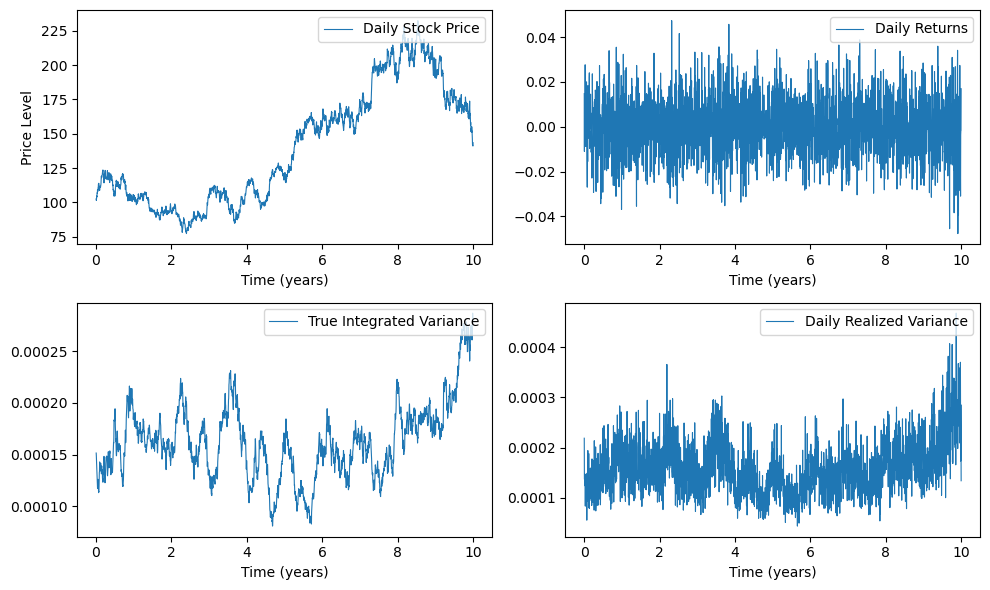

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [6]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001]) 
# 1e-02, 1e-04, 8e-04, 4e-04, 3.16325904e-06

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40228D+04    |proj g|=  2.01000D-01

At iterate    1    f= -1.40238D+04    |proj g|=  2.00777D-01

At iterate    2    f= -1.40467D+04    |proj g|=  3.78018D+04

At iterate    3    f= -1.40741D+04    |proj g|=  3.95467D+03

At iterate    4    f= -1.40742D+04    |proj g|=  9.85711D+02

At iterate    5    f= -1.40742D+04    |proj g|=  9.62640D+02

At iterate    6    f= -1.40742D+04    |proj g|=  7.18876D+02

At iterate    7    f= -1.40743D+04    |proj g|=  3.41776D+02

At iterate    8    f= -1.40743D+04    |proj g|=  5.34222D+02

At iterate    9    f= -1.40743D+04    |proj g|=  3.90132D+02

At iterate   10    f= -1.40744D+04    |proj g|=  5.80892D+02

At iterate   11    f= -1.40745D+04    |proj g|=  1.54812D+03

At iterate   12    f= -1.40746D+04    |proj g|=  1.23922D+03

At iterate   13    f= -1.4

### Both - Corr

In [7]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])
# initial_params_both_corr = np.array([0.1, 0.01, 0.01, 0.001, 0.001, -0.1])

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40322D+04    |proj g|=  7.89092D+04

At iterate    1    f= -1.40332D+04    |proj g|=  3.74336D+02

At iterate    2    f= -1.40361D+04    |proj g|=  4.05035D+02

At iterate    3    f= -1.40456D+04    |proj g|=  3.10836D+05

At iterate    4    f= -1.40578D+04    |proj g|=  1.36123D+05

At iterate    5    f= -1.40696D+04    |proj g|=  8.90000D-01

At iterate    6    f= -1.40748D+04    |proj g|=  4.10065D+04

At iterate    7    f= -1.40777D+04    |proj g|=  9.68909D+04


/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



At iterate    8    f= -1.40913D+04    |proj g|=  4.79938D+02
  ys=-3.597E+01  -gs= 4.245E+00 BFGS update SKIPPED

QMLE Results for Heston Model:
At iterate    9    f= -1.40913D+04    |proj g|=  4.79938D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     21     14     1     1   4.799D+02  -1.409D+04
  F =  -14091.304380958492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

--------------------------------------------------
kappa: 0.015004
theta: 0.000157
xi: 0.000049
mu: 0.000918
sigma: 0.000711
rho: -0.100000
Negative Log-Likelihood: -14091.304381
Convergence: True
------------------

### Return

In [8]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74833D+03    |proj g|=  4.57287D+05

At iterate    1    f= -3.09859D+03    |proj g|=  1.29176D+02

At iterate    2    f= -3.15165D+03    |proj g|=  1.88464D+02

At iterate    3    f= -3.15167D+03    |proj g|=  2.64976D+04

At iterate    4    f= -3.17178D+03    |proj g|=  2.97889D+05

At iterate    5    f= -3.39601D+03    |proj g|=  1.40041D+06

At iterate    6    f= -3.40140D+03    |proj g|=  1.81677D+06

At iterate    7    f= -3.60815D+03    |proj g|=  9.10022D+00

At iterate    8    f= -3.70371D+03    |proj g|=  1.60312D+03

At iterate    9    f= -3.72043D+03    |proj g|=  3.29861D+01

At iterate   10    f= -3.72083D+03    |proj g|=  7.15541D+04

At iterate   11    f= -3.72085D+03    |proj g|=  9.51473D+04

At iterate   12    f= -3.72100D+03    |proj g|=  1.72517D+05

At iterate   13    f= -3.7

### Return - Corr

In [9]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.43769D+03    |proj g|=  1.93036D+05

At iterate    1    f= -3.62202D+03    |proj g|=  6.41282D+06

At iterate    2    f= -3.70815D+03    |proj g|=  4.24965D+01

At iterate    3    f= -3.71137D+03    |proj g|=  4.39137D+01

At iterate    4    f= -3.71523D+03    |proj g|=  3.07381D+05

At iterate    5    f= -3.71662D+03    |proj g|=  5.04301D+01

At iterate    6    f= -3.71675D+03    |proj g|=  5.18262D+01

At iterate    7    f= -3.71676D+03    |proj g|=  3.28376D+03

At iterate    8    f= -3.71678D+03    |proj g|=  1.54609D+04

At iterate    9    f= -3.71683D+03    |proj g|=  4.32185D+04

At iterate   10    f= -3.71697D+03    |proj g|=  8.34359D+04

At iterate   11    f= -3.71732D+03    |proj g|=  1.51294D+05

At iterate   12    f= -3.71819D+03    |proj g|=  2.52052D+05

At iterate   13    f= -3.7

### RV

In [10]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
test_result_rv = hkf_rv_test.filter(params=params_opt_rv, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.48354D+03    |proj g|=  1.44826D+06

At iterate    1    f= -9.86837D+03    |proj g|=  4.44091D+02

At iterate    2    f= -1.10023D+04    |proj g|=  3.38911D-03

At iterate    3    f= -1.10474D+04    |proj g|=  2.91992D+04

At iterate    4    f= -1.10478D+04    |proj g|=  1.99714D+00

At iterate    5    f= -1.10483D+04    |proj g|=  1.93654D+03

At iterate    6    f= -1.10511D+04    |proj g|=  2.29752D+04

At iterate    7    f= -1.10516D+04    |proj g|=  5.79999D+03

At iterate    8    f= -1.10518D+04    |proj g|=  1.47316D+03

At iterate    9    f= -1.10518D+04    |proj g|=  3.66063D+02

At iterate   10    f= -1.10518D+04    |proj g|=  4.63228D+02

At iterate   11    f= -1.10518D+04    |proj g|=  5.02493D+02

At iterate   12    f= -1.10519D+04    |proj g|=  1.48508D+03

At iterate   13    f= -1.1

### PF

In [26]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 2),        # kappa
    (0.02, 0.03),    # theta
    (0.05, 0.1),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 869.1350162312511
resampling since: 97.40168588960479
resampling since: 2656.10320847372
resampling since: 516.5118645090612
resampling since: 815.8890209959352
resampling since: 187.51210358668132
resampling since: 3358.6674145514926
resampling since: 1705.783170206231
resampling since: 1082.75375634101
resampling since: 1931.9043390715667
resampling since: 3151.772008206399
resampling since: 2057.7456113779567
resampling since: 2178.329929328064
resampling since: 1508.7682042643114
resampling since: 2862.072515212202
resampling since: 2380.0693350396277
resampling since: 950.2022731046438
resampling since: 2370.495923704431
resampling since: 1605.1457799504306
resampling since: 2107.1219304577844
resampling since: 3245.013730470653
resampling since: 2484.9142123981505
resampling since: 3475.277700395508
resampling since: 3272.6192646759087
resampling since: 2335.7305427536917
resampling since: 2952.919990479029
resampling since: 2813.131214225432
resampling since: 2

In [27]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 3310.1820187526805
resampling since: 2856.0280721542567
resampling since: 3402.067245897499
resampling since: 2613.662258646849
resampling since: 3454.7098000996043
resampling since: 3316.9832908659096
resampling since: 3381.53595028505
resampling since: 3435.0865349864225
resampling since: 2917.5793963889323
resampling since: 3455.1654408957556
resampling since: 2289.420530811106
resampling since: 3353.5105157392422
resampling since: 3100.443650384237
resampling since: 3125.1863732697
resampling since: 2656.8562704000183
resampling since: 3492.2021121129515
resampling since: 3422.638010746965
resampling since: 3439.087946716959
resampling since: 3470.1978942355
resampling since: 3439.632559386531
resampling since: 3420.405451639439
resampling since: 2936.5809947106027
resampling since: 3396.894278190752
resampling since: 3108.611846937806
resampling since: 3465.3505857745763
resampling since: 2193.8837597107695
resampling since: 3386.228385745448
resampling since: 29

In [28]:
V_pf_train_daily = V_pf_train / 500
V_pf_test_daily = V_pf_test / 500

## Plot

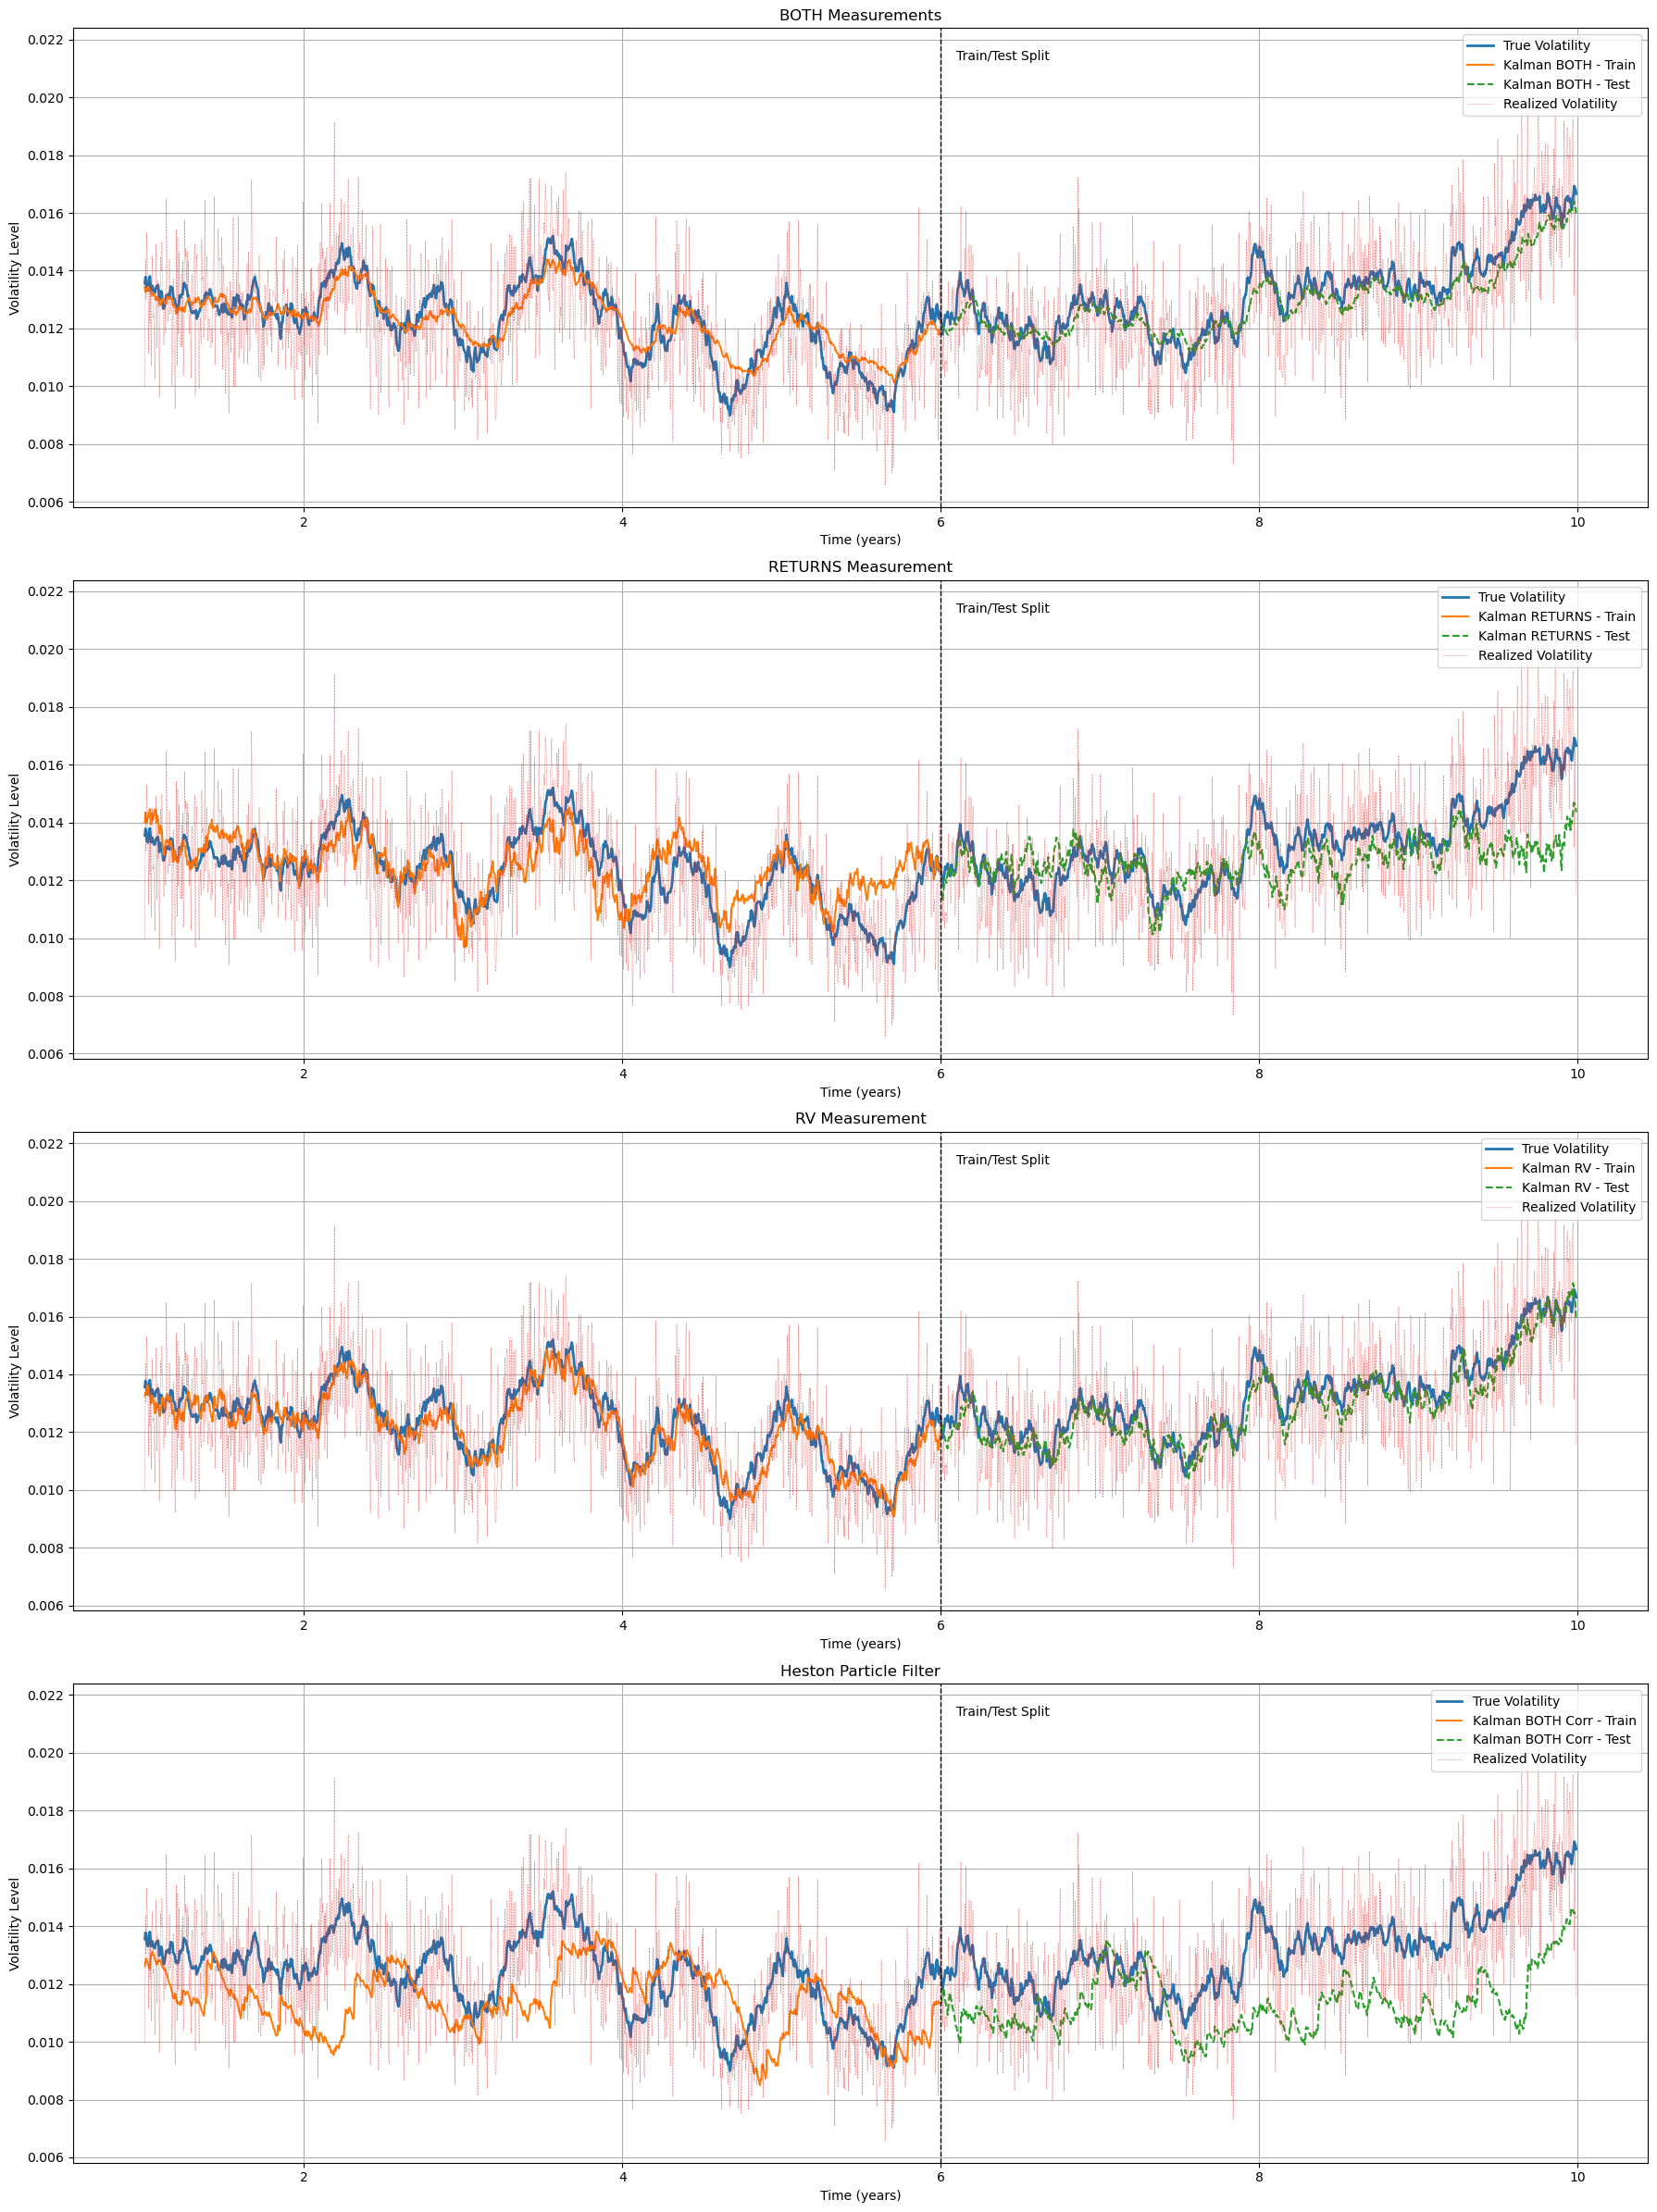

In [29]:
v_item = 'V_filt'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], train_result_rv[v_item], V_pf_train_daily]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], test_result_rv[v_item], V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252, 
    save_path=r"./output/lowVol.png"
)

In [30]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['both_corr', 'returns_corr', 'rv', 'pf']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
mape_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, test_all):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    mape_scores[name]  = mean_absolute_percentage_error(true_volatilities, pred_vol) * 100
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results including QLIKE:")
for name in model_names:
    print(f"{name:12s} MAE: {mae_scores[name]:.6f}, "
          f"RMSE: {rmse_scores[name]:.6f}, "
          f"MAPE: {mape_scores[name]:.3f}%, "
          f"QLIKE: {qlike_scores[name]:.6f}")


Results including QLIKE:
both_corr    MAE: 0.000475, RMSE: 0.000588, MAPE: 3.519%, QLIKE: 0.003931
returns_corr MAE: 0.000923, RMSE: 0.001233, MAPE: 6.674%, QLIKE: 0.017723
rv           MAE: 0.000425, RMSE: 0.000536, MAPE: 3.217%, QLIKE: 0.003546
pf           MAE: 0.002049, RMSE: 0.002316, MAPE: 15.074%, QLIKE: 0.081469


In [16]:
import pandas as pd
data = {}

data['both_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    params_opt_both_corr
))

data['returns_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    params_opt_returns_corr
))
data['returns_corr']['sigma'] = np.nan

data['rv'] = dict(zip(
    ['kappa', 'theta', 'xi', 'sigma'],
    params_opt_rv
))
data['rv']['mu']  = np.nan
data['rv']['rho'] = np.nan

pf_vals = estimated_param[:, -1]
data['pf'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,both_corr,returns_corr,rv,pf
kappa,0.015004,0.026227,0.007660,1.474198
theta,0.000157,0.000156,0.000144,0.025209
xi,0.000049,0.006441,0.000352,0.254211
mu,0.000918,0.000395,NaN,-0.010713
sigma,0.000711,NaN,0.002936,NaN
rho,-0.100000,0.001332,NaN,-0.230777


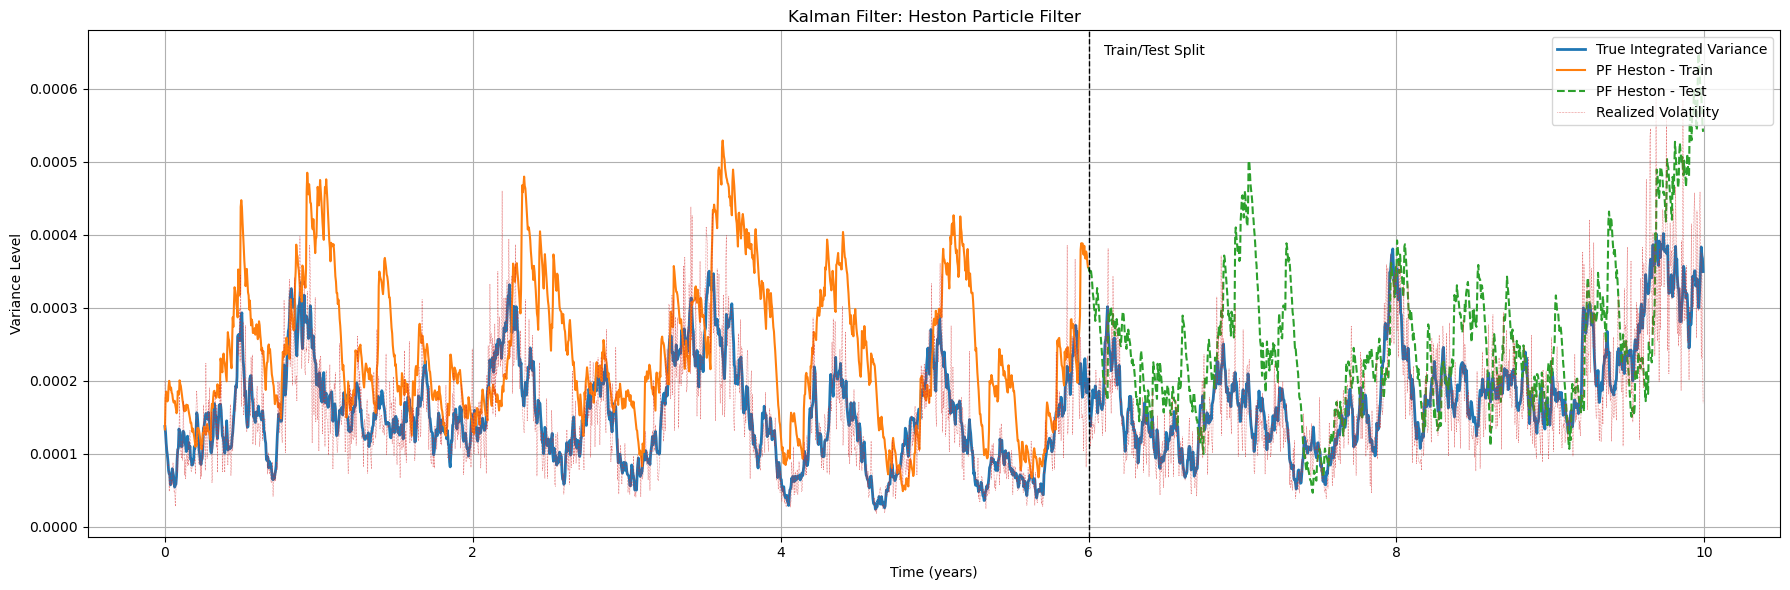

In-Sample RMSE (Heston Particle Filter): 0.000122
Out-of-Sample RMSE (Heston Particle Filter): 0.000110


(0.00012217167608488048, 0.00011009081122822449)

In [27]:
Utility.plot_filter_result(
    plot_index=5,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)